In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from surrogate_FEM import *
from sklearn.metrics import r2_score

In [2]:
from modules.pinn_2d import *
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("./data/results_R2.csv", names=['E', 'DNN-1', 'DNN-2', 'DNN-3', 'PINN'])
df

,E,DNN-1,DNN-2,DNN-3,PINN
0,1.5,0.8350,0.8695,0.8597,0.9666
1,5.0,0.9961,0.9957,0.9957,0.9966
2,9.0,0.9950,0.9942,0.9938,0.9956
3,12.0,0.9653,0.9686,0.9763,0.9808
4,14.0,0.8700,0.8912,0.9249,0.9182
5,2.0,0.9975,0.9982,0.9976,0.9979
6,4.0,0.9978,0.9966,0.9967,0.9971
7,6.0,0.9960,0.9960,0.9957,0.9965
8,8.0,0.9949,0.9949,0.9944,0.9959
9,10.0,0.9939,0.9922,0.9922,0.9943


In [5]:
df = df.sort_values(by=['E'])
df

,E,DNN-1,DNN-2,DNN-3,PINN
0,1.5,0.8350,0.8695,0.8597,0.9666
5,2.0,0.9975,0.9982,0.9976,0.9979
6,4.0,0.9978,0.9966,0.9967,0.9971
1,5.0,0.9961,0.9957,0.9957,0.9966
7,6.0,0.9960,0.9960,0.9957,0.9965
8,8.0,0.9949,0.9949,0.9944,0.9959
2,9.0,0.9950,0.9942,0.9938,0.9956
9,10.0,0.9939,0.9922,0.9922,0.9943
3,12.0,0.9653,0.9686,0.9763,0.9808
4,14.0,0.8700,0.8912,0.9249,0.9182


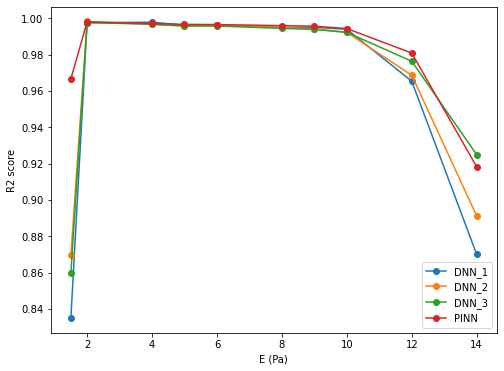

In [6]:
plt.figure(figsize=(8, 6))
df = df[(df['E'] > 1)]
plt.plot(df['E'], df['DNN-1'],  marker='o', label='DNN_1')
plt.plot(df['E'], df['DNN-2'],  marker='o', label='DNN_2')
plt.plot(df['E'], df['DNN-3'],  marker='o', label='DNN_3')
plt.plot(df['E'], df['PINN'],  marker='o', label='PINN')
plt.xlabel('E (Pa)')
plt.ylabel('R2 score')
plt.legend()
plt.savefig('data_final/figures/surrogate/results_r2.png')

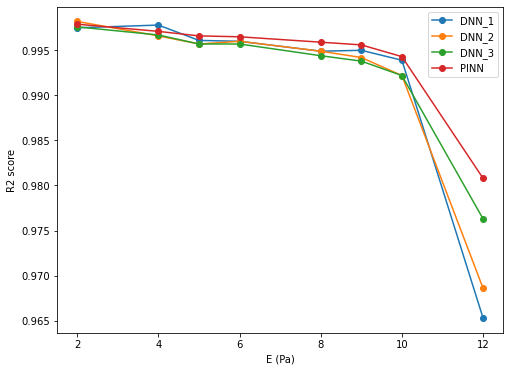

In [7]:
df = df[(df['E'] >= 2) & (df['E'] <= 12)]

plt.figure(figsize=(8, 6))
plt.plot(df['E'], df['DNN-1'],  marker='o', label='DNN_1')
plt.plot(df['E'], df['DNN-2'],  marker='o', label='DNN_2')
plt.plot(df['E'], df['DNN-3'],  marker='o', label='DNN_3')
plt.plot(df['E'], df['PINN'],  marker='o', label='PINN')
plt.xlabel('E (Pa)')
plt.ylabel('R2 score')
plt.legend()
plt.savefig('data_final/figures/surrogate/results_r2_zoomed.png')

In [4]:
node_num = 100000
epochs = 10000

In [3]:
since = time.time()

fpath = "./models/2d_plane_sur_10000nodes_no_interface_ref2.data"
state_dict = torch.load(fpath)

points_x = [(-1.0, 0.0), (0.0, 1.0)]
points_y = [(-1.0, 1.0), (-1.0, 1.0)]

# Set the number of domains
domain_no = len(points_x)

# Set the global left & right boundary of the calculation domain
global_lb_x = -1.0
global_rb_x = 1.0
global_lb_y = -1.0
global_rb_y = 1.0

# Initialize CPINN model
model_pinn = CPINN_2D_surrogate(domain_no, global_lb_x, global_rb_x, global_lb_y, global_rb_y, figure_path=None)

# to do
model_pinn.make_domains(points_x, points_y)
model_pinn.make_boundaries()

sample = {'Model{}'.format(i+1): PINN_surrogate(i) for i in range(domain_no)}
# sample = {'Model{}'.format(i+1): PINN_plate(i) for i in range(domain_no)}

model_pinn.module_update(sample)

model_pinn.load_state_dict(state_dict)

model_pinn = model_pinn.cuda()

N = 5

data = np.loadtxt("./data/surrogate/cpinn_10000nodes/6_full_data.txt")

x, y, u, v = data.T

x = np.arange(-1, 1.005, 0.005)
y = np.arange(-1, 1.005, 0.005)

xy = np.meshgrid(x,y)

x, y = xy

x = x.reshape(-1,1)
y = y.reshape(-1,1)

x_t = torch.tensor(x).type(torch.FloatTensor).cuda()
y_t = torch.tensor(y).type(torch.FloatTensor).cuda()
e_t = (torch.ones(x_t.shape) * N).cuda()

pred = model_pinn(x_t, y_t, e_t)

u_pred = pred[:,0].cpu().detach().numpy().reshape(-1, 1).T
v_pred = pred[:,1].cpu().detach().numpy().reshape(-1, 1).T
x = x.T
y = y.T

df = pd.DataFrame(np.vstack((x, y, u_pred, v_pred)).T, columns=['x', 'y', 'u', 'v'])


df.to_csv("test.csv")

print("Elapsed time: {:.2f} s".format(time.time() - since))

[{'x_lb': 0.0, 'x_rb': 0.0, 'y_lb': -1.0, 'y_rb': 1.0, 'domains': [0, 1]}]
Elapsed time: 3.81 s


In [42]:
fpath = './models/surrogate_FEM/cpinn_{}nodes_{}epochs_sd_1.data'.format(node_num, epochs)

state_dict = torch.load(fpath)
model = MLP_simple()
model.load_state_dict(state_dict)

model = model.cuda()

fpath = './models/surrogate_FEM/cpinn_{}nodes_{}epochs_sd_2.data'.format(node_num, epochs)
state_dict = torch.load(fpath)
model2 = MLP_simple()
model2.load_state_dict(state_dict)

model2 = model2.cuda()

fpath = "./models/2d_plane_sur_10000nodes_no_interface_ref2.data"
state_dict = torch.load(fpath)

points_x = [(-1.0, 0.0), (0.0, 1.0)]
points_y = [(-1.0, 1.0), (-1.0, 1.0)]

# Set the number of domains
domain_no = len(points_x)

# Set the global left & right boundary of the calculation domain
global_lb_x = -1.0
global_rb_x = 1.0
global_lb_y = -1.0
global_rb_y = 1.0

# Initialize CPINN model
model_pinn = CPINN_2D_surrogate(domain_no, global_lb_x, global_rb_x, global_lb_y, global_rb_y, figure_path=None)

# to do
model_pinn.make_domains(points_x, points_y)
model_pinn.make_boundaries()

sample = {'Model{}'.format(i+1): PINN_surrogate(i) for i in range(domain_no)}
# sample = {'Model{}'.format(i+1): PINN_plate(i) for i in range(domain_no)}

model_pinn.module_update(sample)

model_pinn.load_state_dict(state_dict)

model_pinn = model_pinn.cuda()
    
for N in [1.5, 2, 4, 5, 6, 8, 9, 10, 12, 14]:
    
    data = np.loadtxt("./data/surrogate/cpinn_10000nodes/6_full_data.txt")
    # data = np.loadtxt("./data/surrogate/10.txt")
    x, y, u, v = data.T

    x_s = np.random.uniform(-1, 1, (x.shape))
    y_s = np.random.uniform(-1, 1, (x.shape))

    x_1, y_1 = x[x <= 0], y[x <= 0]
    x_2, y_2 = x[x > 0], y[x > 0]



    x_t = torch.tensor(x_1).unsqueeze(0).T.type(torch.FloatTensor).cuda()
    y_t = torch.tensor(y_1).unsqueeze(0).T.type(torch.FloatTensor).cuda()
    e_t = (torch.ones(x_t.shape) * N).cuda()

    x_t_2 = torch.tensor(x_2).unsqueeze(0).T.type(torch.FloatTensor).cuda()
    y_t_2 = torch.tensor(y_2).unsqueeze(0).T.type(torch.FloatTensor).cuda()
    e_t_2 = (torch.ones(x_t_2.shape) * N).cuda()

    pred = model(x_t, y_t, e_t)
    pred2 = model2(x_t_2, y_t_2, e_t_2)

    ground_truth = np.loadtxt("./data/surrogate/cpinn_10000nodes/{}_full_data.txt".format(N))
    x, y, u, v = ground_truth.T

    x_1_gt, y_1_gt, u_1_gt, v_1_gt = x[x<=0], y[x<=0], u[x<=0], v[x<=0]
    x_2_gt, y_2_gt, u_2_gt, v_2_gt = x[x>0], y[x>0], u[x>0], v[x>0]

    u_pred = pred[:,0].cpu().detach().numpy()
    v_pred = pred[:,1].cpu().detach().numpy()

    u_diff = abs(u_pred - u_1_gt)
    v_diff = abs(v_pred - v_1_gt)

    u_pred2 = pred2[:,0].cpu().detach().numpy()
    v_pred2 = pred2[:,1].cpu().detach().numpy()

    u_diff2 = abs(u_pred2 - u_2_gt)
    v_diff2 = abs(v_pred2 - v_2_gt)
    print("DNN {}".format(N))
    print("u: {:.6f}".format( np.sqrt((np.sum(u_diff ** 2) + np.sum(u_diff2 ** 2)) / (np.sum(u_1_gt ** 2) + np.sum(u_2_gt ** 2)))))
    print("v: {:.6f}".format( np.sqrt((np.sum(v_diff ** 2) + np.sum(v_diff2 ** 2)) / (np.sum(v_1_gt ** 2) + np.sum(v_2_gt ** 2)))))
    print("sum: {:.6f}".format( np.sqrt((np.sum(u_diff ** 2) + np.sum(u_diff2 ** 2) + np.sum(v_diff ** 2) + np.sum(v_diff2 ** 2) )  / ( np.sum(u_1_gt ** 2) + np.sum(u_2_gt ** 2) + np.sum(v_1_gt ** 2) + np.sum(v_2_gt ** 2)))))
    u_merged = np.concatenate((u_pred, u_pred2))
    v_merged = np.concatenate((v_pred, v_pred2))
    u_gt_merged = np.concatenate((u_1_gt, u_2_gt))
    v_gt_merged = np.concatenate((v_1_gt, v_2_gt))
    pred_m = np.concatenate((u_merged, v_merged))
    gt_m = np.concatenate((u_gt_merged, v_gt_merged))
    print("R2: {:.4f}".format(r2_score(pred_m, gt_m)))

[{'x_lb': 0.0, 'x_rb': 0.0, 'y_lb': -1.0, 'y_rb': 1.0, 'domains': [0, 1]}]
DNN 1.5
u: 0.165671
v: 0.171503
sum: 0.169703
R2: 0.8597
DNN 2
u: 0.035114
v: 0.022249
sum: 0.026935
R2: 0.9976
DNN 4
u: 0.039870
v: 0.027896
sum: 0.032118
R2: 0.9967
DNN 5
u: 0.044195
v: 0.030968
sum: 0.035630
R2: 0.9957
DNN 6
u: 0.045441
v: 0.029641
sum: 0.035342
R2: 0.9957
DNN 8
u: 0.051795
v: 0.034829
sum: 0.040891
R2: 0.9944
DNN 9
u: 0.056483
v: 0.035791
sum: 0.043328
R2: 0.9938
DNN 10
u: 0.063444
v: 0.040482
sum: 0.048827
R2: 0.9922
DNN 12
u: 0.098713
v: 0.080579
sum: 0.086651
R2: 0.9763
DNN 14
u: 0.171046
v: 0.152838
sum: 0.158749
R2: 0.9249


In [43]:
fpath = './models/surrogate_FEM/cpinn_{}nodes_{}epochs_sd_1.data'.format(node_num, epochs)
# fpath = "./models/surrogate_FEM/test.data"
state_dict = torch.load(fpath)
model = MLP_simple()
model.load_state_dict(state_dict)

model = model.cuda()

In [2477]:
fpath = './models/surrogate_FEM/cpinn_{}nodes_{}epochs_sd_2.data'.format(node_num, epochs)
# fpath = "./models/surrogate_FEM/test.data"
state_dict = torch.load(fpath)
model2 = MLP_simple()
model2.load_state_dict(state_dict)

model2 = model2.cuda()

In [2536]:
N = 14

In [2537]:
data = np.loadtxt("./data/surrogate/cpinn_10000nodes/6_full_data.txt")
# data = np.loadtxt("./data/surrogate/10.txt")
x, y, u, v = data.T

x_s = np.random.uniform(-1, 1, (x.shape))
y_s = np.random.uniform(-1, 1, (x.shape))

x_1, y_1 = x[x <= 0], y[x <= 0]
x_2, y_2 = x[x > 0], y[x > 0]



x_t = torch.tensor(x_1).unsqueeze(0).T.type(torch.FloatTensor).cuda()
y_t = torch.tensor(y_1).unsqueeze(0).T.type(torch.FloatTensor).cuda()
e_t = (torch.ones(x_t.shape) * N).cuda()

x_t_2 = torch.tensor(x_2).unsqueeze(0).T.type(torch.FloatTensor).cuda()
y_t_2 = torch.tensor(y_2).unsqueeze(0).T.type(torch.FloatTensor).cuda()
e_t_2 = (torch.ones(x_t_2.shape) * N).cuda()

In [2538]:
pred = model(x_t, y_t, e_t)
pred2 = model2(x_t_2, y_t_2, e_t_2)

Text(0.5, 1.0, 'MLP_14')

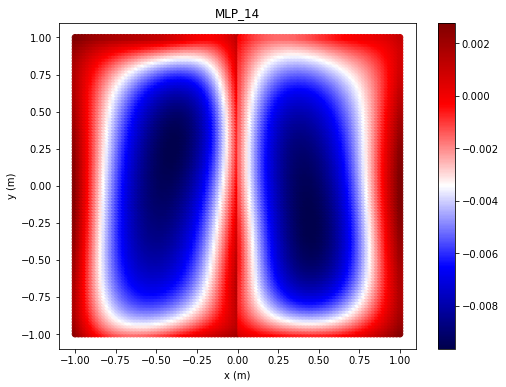

In [2539]:
plt.figure(figsize=(8, 6))
plt.scatter(x_1, y_1, c=pred[:,0].cpu().detach().numpy(), cmap='seismic')
plt.scatter(x_2, y_2, c=pred2[:,0].cpu().detach().numpy(), cmap='seismic')
plt.colorbar()
# plt.clim(-0.5, 1.0)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("MLP_{}".format(N))
# plt.savefig("data_final/figures/surrogate/{}/MLP_u_{}.png".format(node_num, N))

Text(0.5, 1.0, 'MLP_14')

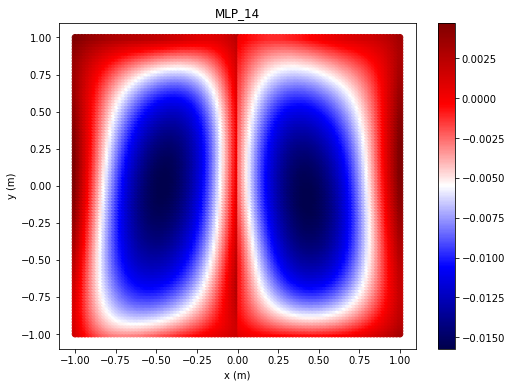

In [2540]:
plt.figure(figsize=(8, 6))
plt.scatter(x_1, y_1, c=pred[:,1].cpu().detach().numpy(), cmap='seismic')
plt.scatter(x_2, y_2, c=pred2[:,1].cpu().detach().numpy(), cmap='seismic')
plt.colorbar()
# plt.clim(-0.5, 1.0)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("MLP_{}".format(N))
# plt.savefig("data_final/figures/surrogate/{}/MLP_v_{}.png".format(node_num, N))

In [2541]:
x_np = np.concatenate((x_1, x_2)).reshape(-1,1)
y_np = np.concatenate((y_1, y_2)).reshape(-1,1)
u_np = np.concatenate((pred[:,0].cpu().detach().numpy(), pred2[:,0].cpu().detach().numpy())).reshape(-1,1)
v_np = np.concatenate((pred[:,1].cpu().detach().numpy(), pred2[:,1].cpu().detach().numpy())).reshape(-1,1)
df = pd.DataFrame(np.concatenate((x_np, y_np, u_np, v_np), axis=1), columns=['x', 'y', 'u', 'v'])
df = df.sort_values(by=['x', 'y'], axis=0)

In [2542]:
# N = 1.2
# N = 8

In [2543]:
ground_truth = np.loadtxt("./data/surrogate/cpinn_10000nodes/{}_full_data.txt".format(N))
x, y, u, v = ground_truth.T

x_1_gt, y_1_gt, u_1_gt, v_1_gt = x[x<=0], y[x<=0], u[x<=0], v[x<=0]
x_2_gt, y_2_gt, u_2_gt, v_2_gt = x[x>0], y[x>0], u[x>0], v[x>0]

In [2544]:
# N = 4

In [2545]:
# ground_truth = np.loadtxt("./data/surrogate/cpinn_10000nodes/{}_full_data.txt".format(N))
# x, y, u, v = ground_truth.T

# x_3_gt, y_3_gt, u_3_gt, v_3_gt = x[x<=0], y[x<=0], u[x<=0], v[x<=0]
# x_4_gt, y_4_gt, u_4_gt, v_4_gt = x[x>0], y[x>0], u[x>0], v[x>0]

In [2546]:
u_pred = pred[:,0].cpu().detach().numpy()
v_pred = pred[:,1].cpu().detach().numpy()

u_diff = abs(u_pred - u_1_gt)
v_diff = abs(v_pred - v_1_gt)

# diff = np.concatenate((u_diff, v_diff))

In [2547]:
u_pred2 = pred2[:,0].cpu().detach().numpy()
v_pred2 = pred2[:,1].cpu().detach().numpy()

u_diff2 = abs(u_pred2 - u_2_gt)
v_diff2 = abs(v_pred2 - v_2_gt)

In [2561]:
print(np.max(abs(np.concatenate((u_pred, u_pred2)))))
print(np.max(abs(u_1_gt)))

0.009643305
0.008801177446576


Text(0.5, 1.0, 'GT_14')

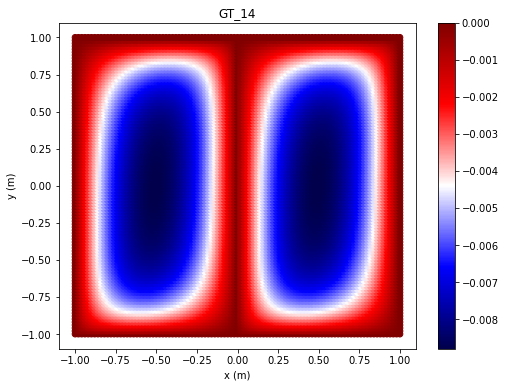

In [2548]:
plt.figure(figsize=(8, 6))
plt.scatter(x_1_gt, y_1_gt, c=u_1_gt, cmap='seismic')
plt.scatter(x_2_gt, y_2_gt, c=u_2_gt, cmap='seismic')
plt.colorbar()
# plt.clim(-0.5, 1.0)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("GT_{}".format(N))
# plt.savefig("data_final/figures/surrogate/FEM_u_{}.png".format(N))

Text(0.5, 1.0, 'GT_14')

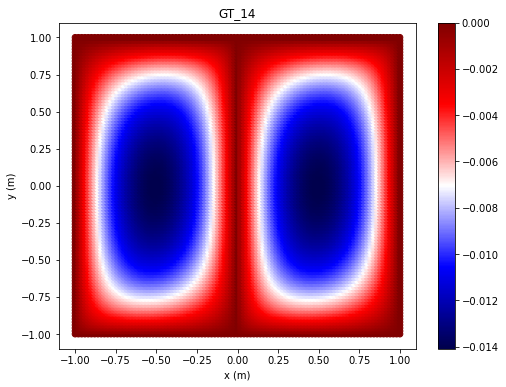

In [2549]:
plt.figure(figsize=(8, 6))
plt.scatter(x_1_gt, y_1_gt, c=v_1_gt, cmap='seismic')
plt.scatter(x_2_gt, y_2_gt, c=v_2_gt, cmap='seismic')
plt.colorbar()
# plt.clim(-0.5, 1.0)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("GT_{}".format(N))
# plt.savefig("data_final/figures/surrogate/FEM_v_{}.png".format(N))

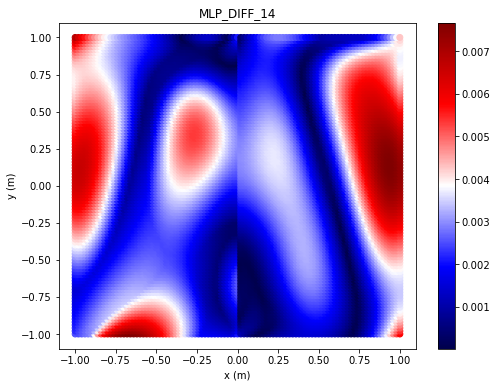

In [2550]:
plt.figure(figsize=(8, 6))
plt.scatter(x_1_gt, y_1_gt, c=u_diff + v_diff, cmap='seismic')
plt.scatter(x_2_gt, y_2_gt, c=u_diff2 + v_diff2, cmap='seismic')
plt.colorbar()
# plt.clim(-0.5, 1.0)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("MLP_DIFF_{}".format(N))
plt.savefig("data_final/figures/surrogate/{}/MLP_AbsErr_{}.png".format(node_num, N))

Text(0.5, 1.0, 'MLP_DIFF_14')

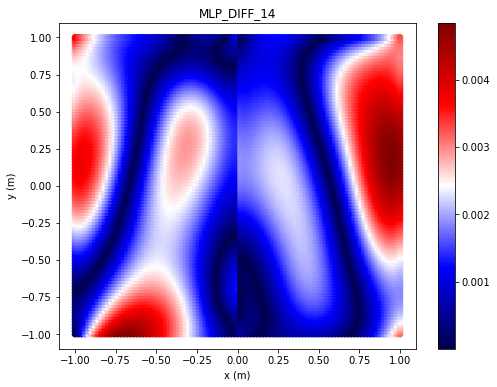

In [2554]:
plt.figure(figsize=(8, 6))
plt.scatter(x_1_gt, y_1_gt, c=v_diff, cmap='seismic')
plt.scatter(x_2_gt, y_2_gt, c=v_diff2, cmap='seismic')
plt.colorbar()
# plt.clim(-0.5, 1.0)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("MLP_DIFF_{}".format(N))
# plt.savefig("data_final/figures/surrogate/{}/MLP_AbsErr_v_{}.png".format(node_num, N))

In [2552]:
print("{:.6f}".format( np.sqrt((np.sum(u_diff ** 2) + np.sum(u_diff2 ** 2)) / (np.sum(u_1_gt ** 2) + np.sum(u_2_gt ** 2)))))
print("{:.6f}".format( np.sqrt((np.sum(v_diff ** 2) + np.sum(v_diff2 ** 2)) / (np.sum(v_1_gt ** 2) + np.sum(v_2_gt ** 2)))))

print("{:.6f}".format( np.sqrt((np.sum(u_diff ** 2) + np.sum(u_diff2 ** 2) + np.sum(v_diff ** 2) + np.sum(v_diff2 ** 2) )  / ( np.sum(u_1_gt ** 2) + np.sum(u_2_gt ** 2) + np.sum(v_1_gt ** 2) + np.sum(v_2_gt ** 2)))))

0.219048
0.244341
0.236732



PINN

In [2495]:
from modules.pinn_2d import *
import matplotlib.pyplot as plt

In [2496]:
# N = 16

In [2562]:
fpath = "./models/2d_plane_sur_10000nodes_no_interface_ref2.data"
# fpath = "./data_final/models/2d_plane_sur_10000nodes_no_interface_lbfgs_6.data"
state_dict = torch.load(fpath)

points_x = [(-1.0, 0.0), (0.0, 1.0)]
points_y = [(-1.0, 1.0), (-1.0, 1.0)]

# Set the number of domains
domain_no = len(points_x)

# Set the global left & right boundary of the calculation domain
global_lb_x = -1.0
global_rb_x = 1.0
global_lb_y = -1.0
global_rb_y = 1.0

# Initialize CPINN model
model_pinn = CPINN_2D_surrogate(domain_no, global_lb_x, global_rb_x, global_lb_y, global_rb_y, figure_path=None)

# to do
model_pinn.make_domains(points_x, points_y)
model_pinn.make_boundaries()

sample = {'Model{}'.format(i+1): PINN_surrogate(i) for i in range(domain_no)}
# sample = {'Model{}'.format(i+1): PINN_plate(i) for i in range(domain_no)}

model_pinn.module_update(sample)

model_pinn.load_state_dict(state_dict)

model_pinn = model_pinn.cuda()


[{'x_lb': 0.0, 'x_rb': 0.0, 'y_lb': -1.0, 'y_rb': 1.0, 'domains': [0, 1]}]


In [2498]:
def make_tensor(x):
    return torch.tensor(x).unsqueeze(0).T.type(torch.FloatTensor).cuda()

In [2499]:

y = y[x != 0]
u = u[x != 0]
v = v[x != 0]
x = x[x != 0]

In [2500]:
x_t = torch.tensor(x).unsqueeze(0).T.type(torch.FloatTensor).cuda()
y_t = torch.tensor(y).unsqueeze(0).T.type(torch.FloatTensor).cuda()
e_t = (torch.ones(x_t.shape) * N).cuda()


# x_t_2 = torch.tensor(x_2).unsqueeze(0).T.type(torch.FloatTensor).cuda()
# y_t_2 = torch.tensor(y_2).unsqueeze(0).T.type(torch.FloatTensor).cuda()
# e_t_2 = (torch.ones(x_t_2.shape) * N).cuda()

In [2501]:
pinn_pred = model_pinn(x_t, y_t, e_t).cpu().detach().numpy()
u_pred_pinn = pinn_pred[:,0]
v_pred_pinn = pinn_pred[:,1]


# pinn_pred_2 = model_pinn(x_t_2, y_t_2, e_t_2).cpu().detach().numpy()
# u_pred_pinn_2 = pinn_pred_2[:,0]
# v_pred_pinn_2 = pinn_pred_2[:,1]

Text(0.5, 1.0, 'PINN_5')

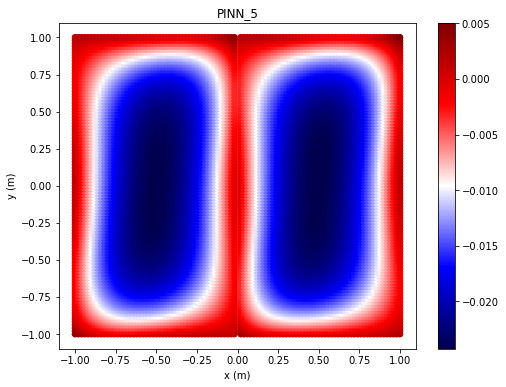

In [2502]:
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=u_pred_pinn, cmap='seismic')
# plt.scatter(x_2, y_2, c=u_pred_pinn_2, cmap='seismic')
plt.colorbar()
# plt.clim(-0.010, 0.0)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("PINN_{}".format(N))
# plt.savefig("data_final/figures/surrogate/PINN_u_{}.png".format(N))

Text(0.5, 1.0, 'PINN_5')

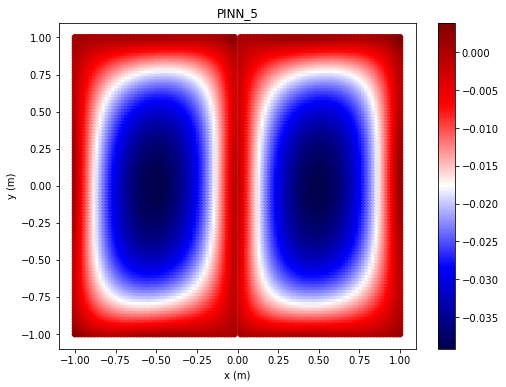

In [2503]:
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=v_pred_pinn, cmap='seismic')
# plt.scatter(x_2, y_2, c=v_pred_pinn_2, cmap='seismic')
plt.colorbar()
# plt.clim(-0.5, 1.0)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("PINN_{}".format(N))
# plt.savefig("data_final/figures/surrogate/PINN_v_{}.png".format(N))

In [2504]:
u_diff_pinn =  abs(u_pred_pinn - u)
v_diff_pinn =  abs(v_pred_pinn - v)

# u_diff_pinn_2 =  abs(u_pred_pinn_2 - u_2_gt)
# v_diff_pinn_2 =  abs(v_pred_pinn_2 - v_2_gt)

Text(0.5, 1.0, 'PINN_5')

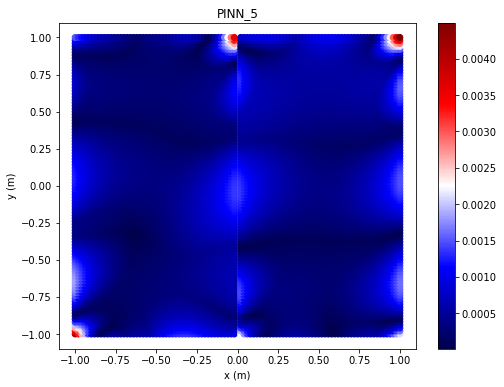

In [2517]:
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=(u_diff_pinn + v_diff_pinn) /2, cmap='seismic')
# plt.scatter(x, y, c=u_diff_pinn_2, cmap='seismic') 
plt.colorbar()
# plt.clim(-0.5, 1.0)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("PINN_{}".format(N))
# plt.savefig("data_final/figures/surrogate/PINN_AbsErr_{}.png".format(N))

Text(0.5, 1.0, 'PINN_5')

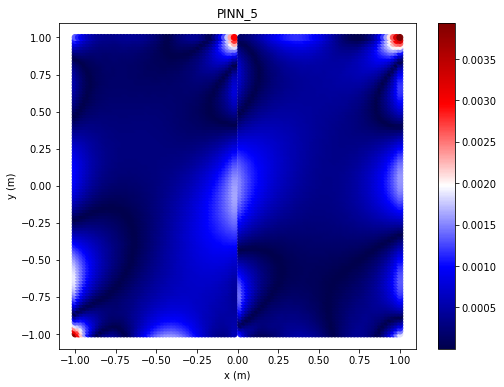

In [2506]:
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=v_diff_pinn, cmap='seismic')
# plt.scatter(x_2, y_2, c=v_diff_pinn_2, cmap='seismic')
plt.colorbar()
# plt.clim(-0.5, 1.0)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("PINN_{}".format(N))
# plt.savefig("data_final/figures/surrogate/PINN_AbsErr_v_{}.png".format(N))

Text(0, 0.5, 'y (m)')

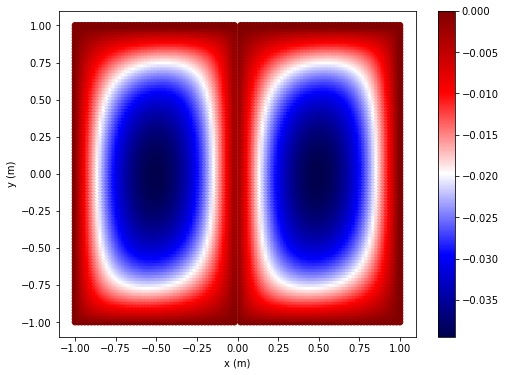

In [2507]:
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=v, cmap='seismic')
# plt.scatter(x_2, y_2, c=v_diff_pinn_2, cmap='seismic')
plt.colorbar()
# plt.clim(-0.5, 1.0)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
# plt.title("PINN_{}".format(N))

In [2518]:
print("{:.6f}".format( np.sum(u_diff_pinn ** 2)  / np.sum(u ** 2) ))
print("{:.6f}".format( np.sum(v_diff_pinn ** 2) / np.sum(v ** 2) ))
print("{:.6f}".format( ( np.sum(u_diff_pinn ** 2) + np.sum(v_diff_pinn ** 2) ) / ( np.sum(u ** 2) + np.sum(v ** 2) ) ))

0.001863
0.000606
0.000999


In [2509]:
np.sum(u**2)

2.251663288005336

In [2510]:
np.sum(v**2)

4.958160838539502

In [2511]:
np.std(u_diff_pinn + v_diff_pinn) / np.mean(u_diff_pinn + v_diff_pinn)

0.6826180460440783

In [2512]:
np.std(np.concatenate((u_diff, u_diff2)) + np.concatenate((v_diff, v_diff2))) / np.mean(np.concatenate((u_diff, u_diff2)) + np.concatenate((v_diff, v_diff2))) 

0.6647470381486014